In [20]:
from __future__ import print_function
import torch

## Key parts of a NN: 

1. Vectorized inputs 
2. Network layers are represented by weights 
3. Loss function e.g. for continuous variables, use MSE, for multi-class classification use categorical cross entropy loss 
4. Optimizer to minimize this loss and update weights 


In [21]:
import torch 

In [22]:
import torch.nn as nn 

In [194]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


## Turning names into tensors

In [195]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [196]:
import random

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Said
category = Italian / line = Muraro
category = Czech / line = Abl
category = Czech / line = Bacon
category = Portuguese / line = Magalhaes
category = Spanish / line = Rana
category = German / line = Adam
category = English / line = Rippin
category = Arabic / line = Khoury
category = Japanese / line = Hideaki


### Define RNN and train 

In [197]:
import torch.nn as nn 

In [198]:
class RNN(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden 
    
    def initHidden(self): 
        return torch.zeros(1, self.hidden_size)
    
    
n_hidden = 128 
rnn = RNN(n_letters, n_hidden, n_categories)
input = lineToTensor('albert')
hidden = rnn.initHidden()
output, next_hidden = rnn.forward(input[0], hidden)
print(categoryFromOutput(output))
# input side in n_letters because we are one-hot encoding all the letters 

('Irish', 8)


#### Training the NN 

In [28]:
criterion = nn.NLLLoss()

In [29]:
def train_rnn(category_tensor, line_tensor): 
    
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]): 
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameter gradients to their values 
    
    for p in rnn.parameters(): 
        p.data.add_(p.grad.data, alpha=-1*learning_rate)
        
    return output, loss.item()
        

In [30]:
learning_rate = 0.005

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_rnn(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 3.5888 O'Driscoll / Polish ✗ (Irish)
10000 10% (0m 11s) 2.2158 Offermans / Greek ✗ (Dutch)
15000 15% (0m 17s) 2.5278 Johnstone / Japanese ✗ (Scottish)
20000 20% (0m 23s) 1.5930 Faure / French ✓
25000 25% (0m 29s) 1.1358 Sokolof / Polish ✓
30000 30% (0m 35s) 1.5072 Sierra / Portuguese ✗ (Spanish)
35000 35% (0m 42s) 0.9153 Krusen / Dutch ✓
40000 40% (0m 48s) 0.7279 Seo / Korean ✓
45000 45% (0m 55s) 0.8209 Song / Korean ✓
50000 50% (1m 1s) 0.0980 Kalakos / Greek ✓
55000 55% (1m 7s) 0.4180 Polymenakou / Greek ✓
60000 60% (1m 13s) 1.9370 Medeiros / Greek ✗ (Portuguese)
65000 65% (1m 19s) 2.5474 Guerra / Spanish ✗ (Italian)
70000 70% (1m 26s) 0.1796 Zouvelekis / Greek ✓
75000 75% (1m 33s) 1.6142 Abascal / French ✗ (Spanish)
80000 80% (1m 39s) 0.1813 Mustafa / Arabic ✓
85000 85% (1m 46s) 1.5564 Diep / Vietnamese ✓
90000 90% (1m 52s) 2.6846 Conn / Chinese ✗ (Irish)
95000 95% (1m 58s) 0.1797 Avgerinos / Greek ✓
100000 100% (2m 4s) 0.1709 Ziemniak / Polish ✓


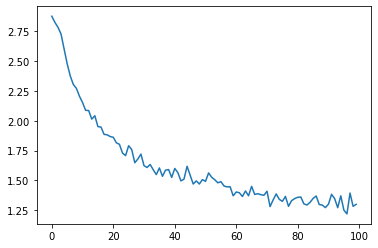

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-33-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-33-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


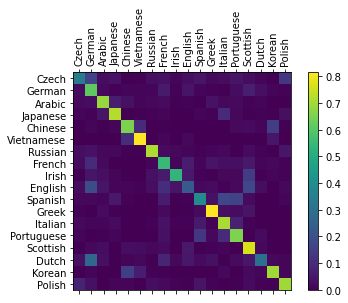

In [33]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [34]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.65) Russian
(-1.08) Czech
(-2.51) Polish

> Jackson
(-0.74) Scottish
(-1.50) English
(-2.05) Russian

> Satoshi
(-1.11) Japanese
(-1.23) Arabic
(-1.63) Italian


In [35]:
predict('Gowardhan')


> Gowardhan
(-1.01) Scottish
(-1.54) English
(-2.08) Dutch


## testing LSTMs

In [354]:
criterion = nn.NLLLoss()

In [355]:
class lstm_test(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size 
        self.lstm_layer = nn.LSTM(input_size, hidden_size,  num_layers= 1, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        output, hidden = self.lstm_layer(input, hidden)
        output = self.linear(hidden[0])
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
    
# input side in n_letters because we are one-hot encoding all the letters 

In [356]:
def train_lstm(category_tensor, line_tensor): 

    hidden = lstm.init_hidden()
    
    lstm.zero_grad()
    
    for i in range(0, line_tensor.size()[0]): 
        output, hidden = lstm.forward(line_tensor[i].view(1,1,-1), hidden)
    
    loss = criterion(output[0], category_tensor)
    loss.backward()
    
    # add parameter gradients to their values 
    
    for p in lstm.parameters(): 
        p.data.add_(p.grad.data, alpha=-1*learning_rate)
        
    return output, loss.item()
        

In [357]:
# input_size, hidden_size, output_size = n_letters, n_hidden, n_categories

In [358]:
lstm = lstm_test(n_letters, n_hidden, n_categories)

In [359]:
# m = nn.LogSoftmax(dim=1)
# loss = nn.NLLLoss()
# # input is of size N x C = 3 x 5
# input = torch.randn(3, 5, requires_grad=True)
# # each element in target has to have 0 <= value < C
# target = torch.tensor([1, 0, 4])
# output = loss(m(input), target)
# output.backward()

In [360]:
# n_hidden = 128 
# input = lineToTensor('agowardh')

# lstm_layer = nn.LSTM(input_size, hidden_size,  num_layers= 2, batch_first=True)
# softmax = nn.LogSoftmax(dim=1)

# output, hidden = lstm_layer(input[0].view(1,1,-1))
# output = softmax(output) 
# print(criterion(output[0], category_tensor))
# output, hidden = lstm_layer(input[0].view(1,1,-1), hidden)
# print(criterion(output[0], category_tensor))
# output, hidden = lstm_layer(input[0].view(1,1,-1), hidden)
# print(criterion(output[0], category_tensor))

# # input side in n_letters because we are one-hot encoding all the le

In [371]:
learning_rate = 0.005

In [ ]:
import time
import math

n_iters = 150000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 3% (1m 8s) 0.0189 Serizawa / Japanese ✓
10000 6% (1m 37s) 0.0020 Zheltouhov / Russian ✓
15000 10% (2m 6s) 0.3266 Mata / Portuguese ✓
20000 13% (2m 36s) 0.0339 Zhadovsky / Russian ✓
25000 16% (3m 8s) 0.0033 Schneijder / Dutch ✓
30000 20% (3m 39s) 1.5196 Krhovsky / Russian ✗ (Czech)
35000 23% (4m 12s) 0.0219 Ienari / Japanese ✓
40000 26% (4m 40s) 0.0465 Lew / Chinese ✓
45000 30% (5m 7s) 0.3127 Ventura / Portuguese ✓
50000 33% (5m 36s) 1.9448 Vinter / German ✗ (Russian)
55000 36% (6m 3s) 0.1289 Colbert / French ✓
60000 40% (6m 26s) 0.0584 Kassis / Arabic ✓
65000 43% (6m 51s) 0.0068 Addario / Italian ✓
70000 46% (7m 25s) 0.0361 Maessen / Dutch ✓
75000 50% (7m 54s) 0.7295 Baarle / Dutch ✓
80000 53% (8m 24s) 0.0516 Andrysiak / Polish ✓
85000 56% (8m 55s) 0.0069 Imeretinsky / Russian ✓
90000 60% (9m 33s) 0.1906 Keighley / English ✓
95000 63% (10m 4s) 0.0667 Hachirobei / Japanese ✓
100000 66% (10m 32s) 1.0449 Riddle / Irish ✗ (English)
105000 70% (11m 2s) 0.0161 Bulgari / Italian ✓
110000

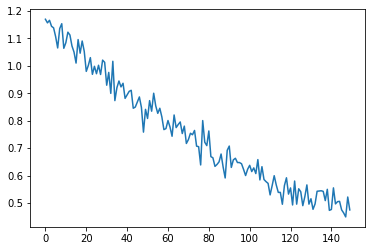

In [365]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-370-7e695061a4c2>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-370-7e695061a4c2>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


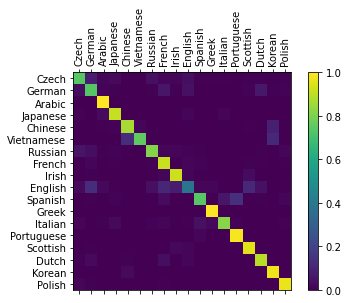

In [370]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    
    
    hidden = lstm.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i].view(1,1,-1), hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Exercises

Play with: 
- regularization 
- find out why ndim 2 
- different output layer 
- different loss function 
- more lstm layers 
- make a transformer layet 

Try with a different dataset of 
- line -> category, for example:
- Any word -> language

- First name -> gender
- Character name -> writer
- Page title -> blog or subreddit
- Get better results with a bigger and/or better shaped network
- Add more linear layers
- Try the nn.LSTM and nn.GRU layers
- Combine multiple of these RNNs as a higher level network
- Using this to classify spam vs no spam  - spam_df = pd.read_csv('./SPAM text message 20170820 - Data.csv')
